In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from itertools import chain
import scienceplots
from cycler import cycler

plt.style.use(["science", "ieee", "std-colors"])
colors = ['#0C5DA5', '#00B945', '#FF9500', '#845B97', '#474747', '#9E9E9E']

plt.rcParams.update({
    "figure.dpi": "100",
    "font.size": 12,
    "axes.prop_cycle": cycler(color=colors),
})

plot_dir = os.path.join("resources", "plots")
os.makedirs(plot_dir, exist_ok=True)

In [29]:
fig_size = (5.333, 3.6)
algo_names = ["AIF", "DQN", "A2C", "PPO"]
max_steps = 40_000
max_eval_steps = 4_000
log_dir = "logs"
save_figures = True

In [30]:
def get_plot_path(file_name):
    return os.path.join(plot_dir, file_name)


def interpolate(x):
    x_valid = np.where(x >= 0)[0]
    y_valid = x[x >= 0]
    interpolated = x.copy()
    interpolated[x < 0] = np.interp(np.where(x < 0)[0], x_valid, y_valid)
    return interpolated


def to_batches(metrics, batch_size=32):
    metrics = metrics.astype(float)

    remainder = len(metrics) % batch_size
    pad_width = batch_size - remainder if remainder > 0 else 0
    metrics = np.pad(
        array=metrics, 
        pad_width=(0, pad_width),
        mode="constant",
        constant_values=np.nan,
    )
    metrics = np.reshape(metrics, (-1, batch_size))

    return np.nanmean(metrics, axis=1), np.nanstd(metrics, axis=1)


def preprocess(df: pd.DataFrame, algo):
    if algo.startswith("AIF"):
        return df
    
    mean_means, mean_stds = to_batches(df["eval_mean_SLO_ALL"])
    var_means, var_stds = to_batches(df["eval_std_SLO_ALL"] ** 2)

    return pd.DataFrame({
        "eval_mean_SLO_ALL": mean_means,
        "eval_std_SLO_ALL": (var_means + mean_stds ** 2) ** 0.5
    })


def rolling(x):
    return x.rolling(15, min_periods=1).mean()


def get_curve(df, name):
    return interpolate(df[name][:max_steps])


def get_eval_curve(df, name):
    return interpolate(df[name][:max_eval_steps])

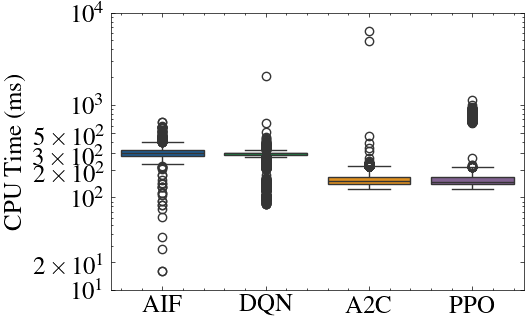

In [31]:
def plot_cpu_usage():
    dir_path = os.path.join(log_dir, "cpu_and_memory")
    logs = [os.path.join(dir_path, f"cm_exp{exp}.csv") for exp in [101, 201, 301, 401]]
    dfs = [pd.read_csv(log) for log in logs]
    algo_names_seq = list(chain(*[[name] * max_steps for name in algo_names]))
    cpu_df = pd.DataFrame({
        "algo": algo_names_seq,
        "values": np.concatenate([get_curve(df, "CPU_time") for df in dfs]),
    })
    
    plt.figure(figsize=fig_size)
    sns.boxplot(cpu_df, x="algo", y="values", hue="algo", log_scale=True)
    plt.yticks(
        [10, 20, 100, 200, 300, 500, 1000, 10000], 
        labels=[
            "$\\mathdefault{10^1}$", 
            "$\\mathdefault{2 \\times 10^1}$", 
            "$\\mathdefault{10^2}$", 
            "$\\mathdefault{2 \\times 10^2}$", 
            "$\\mathdefault{3 \\times 10^2}$" , 
            "$\\mathdefault{5 \\times 10^2}$", 
            "$\\mathdefault{10^3}$", 
            "$\\mathdefault{10^4}$"
        ],
    )
    plt.ylabel("CPU Time (ms)")
    plt.xlabel("")
    if save_figures:
        plt.savefig(get_plot_path("cpu.pdf"))
    plt.show()

with plt.rc_context({"font.size": 18}):
    plot_cpu_usage()

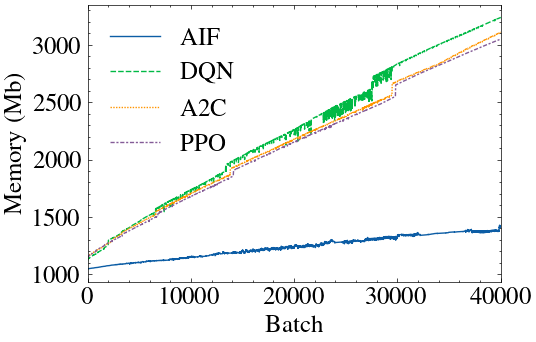

In [32]:
def plot_memory_usage():
    dir_path = os.path.join(log_dir, "cpu_and_memory")
    logs = [os.path.join(dir_path, f"cm_exp{exp}.csv") for exp in [101, 201, 301, 401]]
    dfs = [pd.read_csv(log) for log in logs]
    mem_df = pd.DataFrame({
        "step": range(max_steps),
        **{
            algo: rolling(get_curve(df, "Memory"))
            for algo, df in zip(algo_names, dfs)
        }
    })

    plt.figure(figsize=fig_size)
    sns.lineplot(pd.melt(mem_df, ["step"], var_name="Algorithm"), x="step", y="value", hue="Algorithm", style="Algorithm")
    plt.ylabel("Memory (Mb)")
    plt.xlabel("Batch")
    plt.xlim([0, max_steps])
    plt.xticks([i for i in range(0, max_steps + 1, 10000)])
    plt.legend(loc="upper left")
    if save_figures:
        plt.savefig(get_plot_path("memory.pdf"))
    plt.show()

with plt.rc_context({"font.size": 18}):
    plot_memory_usage()

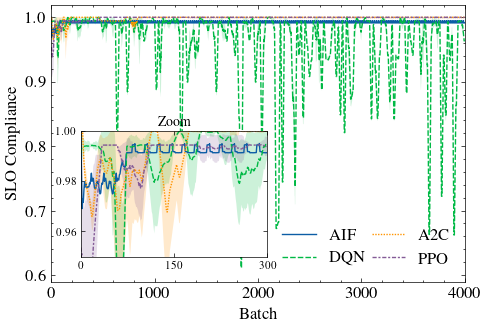

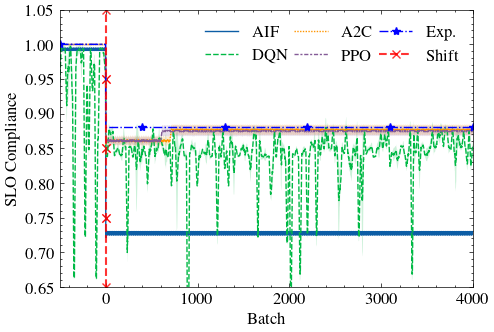

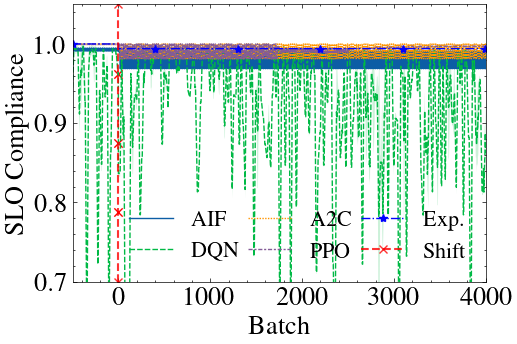

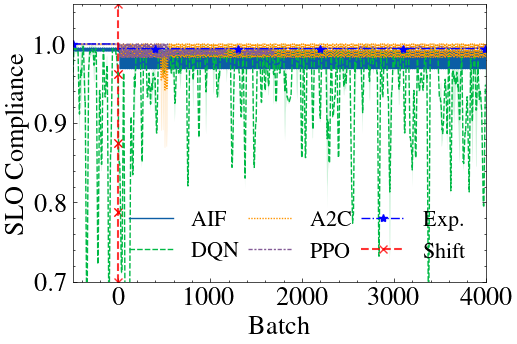

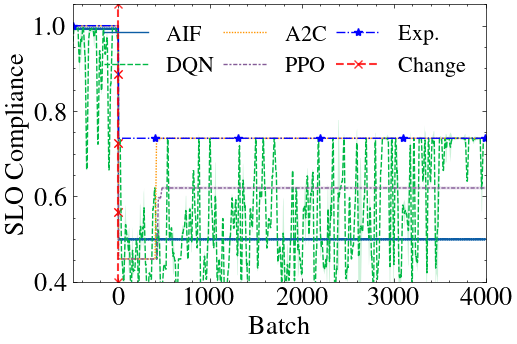

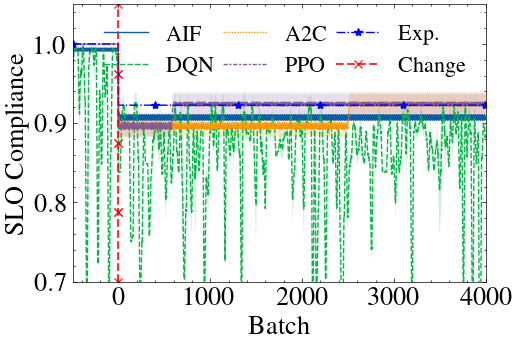

In [58]:
def plot_experiment(
    dir_name,
    zoom_params=None,
    ylim=None,
    smooth=True, 
    expected=None, 
    prepend_base=False, 
    change_label=None,
    legend_loc=None,
    legend_cols=None,
):
    def process(x):
        return rolling(x) if smooth else x
    
    def get_dfs(dir_name):
        dir_path = os.path.join(log_dir, dir_name)
        logs = [os.path.join(dir_path, file_name) for file_name in sorted(os.listdir(dir_path))]
        dfs = [preprocess(pd.read_csv(log), algo) for algo, log in zip(algo_names, logs)]
        return dfs

    prepend_size = 500 if prepend_base else 0

    fig, ax = plt.subplots(figsize=fig_size)
    if prepend_base:
        base_dfs = get_dfs("base_experiment")
    dfs = get_dfs(dir_name)

    def get_algo_and_curve(index, curve_name):
        algo = algo_names[index]
        df = dfs[index]
        curve = process(get_eval_curve(df, curve_name))
        if prepend_base:
            df = base_dfs[index]
            curve = [*process(get_eval_curve(df, curve_name))[-prepend_size:], *curve]
        return algo, curve
    
    def with_std(algo_and_curve):
        return f"{algo_and_curve[0]}_std", algo_and_curve[1]

    df = pd.DataFrame({
        "step": range(-prepend_size, max_eval_steps),
        **dict([
            get_algo_and_curve(index, "eval_mean_SLO_ALL") 
            for index in range(len(algo_names))
        ]),
        **dict([
            with_std(get_algo_and_curve(index, "eval_std_SLO_ALL"))
            for index in range(len(algo_names))
        ]),
    })

    def plot_ax(ax, details=True):
        df_melted = pd.melt(df, ["step"], var_name="Algorithm", value_vars=algo_names)
        sns.lineplot(df_melted, x="step", y="value", hue="Algorithm", style="Algorithm", ax=ax, legend=details, alpha=0.5 if not smooth else 1.)

        for algo in algo_names:
            mean = df[algo]
            std = df[f"{algo}_std"]
            plt.fill_between(range(-prepend_size, max_eval_steps), np.clip(mean - std, 0, 1), np.clip(mean + std, 0, 1), alpha=0.2)

    plot_ax(ax)

    plt.xlim([-prepend_size, max_eval_steps])
    if ylim:
        plt.ylim(ylim)
    plt.xlabel("Batch")
    plt.ylabel("SLO Compliance")

    if expected:
        plt.plot(
            range(-prepend_size, max_eval_steps),
            [1.] * prepend_size + [expected] * max_eval_steps, 
            marker="*", 
            markevery=899, 
            color="b", 
            ls="-.",
            label="Exp."
        )
    if prepend_base:
        plt.axvline(0, color="red", ls="--", linewidth=1.5, alpha=0.8, marker="x", label=change_label or "Change")
        ymin, ymax = plt.ylim()
        delta = (ymax - ymin) / 4
        plt.scatter(x=[0] * 3, y=[ymin + delta * i for i in range(1, 4)], color="red", marker="x")

    ax.legend(loc=legend_loc or "best", ncols=legend_cols or 1, columnspacing=0.4)
    ax.set_xticks([i for i in range(0, max_eval_steps + 1, 1000)])

    if zoom_params:
        zoom_ax = plt.axes(zoom_params["axes"])
        plot_ax(zoom_ax, details=False)
        zoom_ax.tick_params(labelsize=8)
        zoom_ax.set_xlim(zoom_params["xlim"])
        zoom_ax.set_ylim(zoom_params["ylim"])
        zoom_ax.set_title("Zoom", fontdict={"fontsize": 10}, pad=4)
        zoom_ax.set_xlabel("")
        zoom_ax.set_ylabel("")
        zoom_ax.xaxis.set_minor_locator(ticker.NullLocator())
        zoom_ax.yaxis.set_minor_locator(ticker.NullLocator())
        zoom_ax.xaxis.set_major_locator(ticker.MaxNLocator(2))
        zoom_ax.yaxis.set_major_locator(ticker.MaxNLocator(3))

    if save_figures:
        plt.savefig(get_plot_path(f"slo_eval_exp_{dir_name}.pdf"))
    plt.show()

plot_experiment(
    "base_experiment",
    zoom_params=dict(
        axes=[0.18, 0.18, 0.35, 0.35],
        xlim=[0, 300],
        ylim=[0.95, 1.],
    ),
    legend_loc="lower right",
    legend_cols=2,
)
plot_experiment("rate_limit", expected=0.8800, prepend_base=True, change_label="Shift", legend_loc="upper right", legend_cols=3, ylim=[0.65, 1.05])

with plt.rc_context({"font.size": 19, "legend.fontsize": 16}):
    plot_experiment("heating_k03", expected=0.9941, smooth=True, prepend_base=True, change_label="Shift", legend_loc="lower right", legend_cols=3, ylim=[0.7, 1.05])
    plot_experiment("heating_k07", expected=0.9941, smooth=True, prepend_base=True, change_label="Shift", legend_loc="lower right", legend_cols=3, ylim=[0.7, 1.05])
    plot_experiment("change_slos1", expected=0.7360, prepend_base=True, change_label="Change", legend_loc="upper right", legend_cols=3, ylim=[0.4, 1.05])
    plot_experiment("change_slos2", expected=0.9227, prepend_base=True, change_label="Change", legend_loc="upper right", legend_cols=3, ylim=[0.7, 1.05])

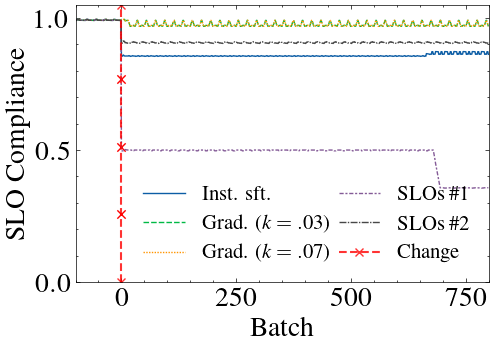

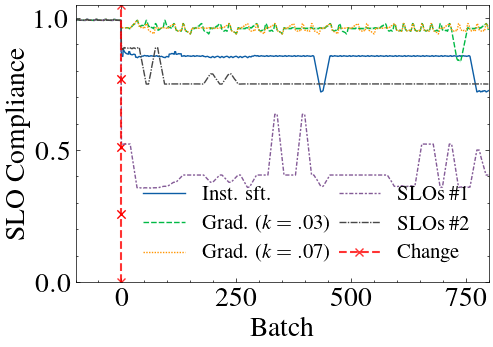

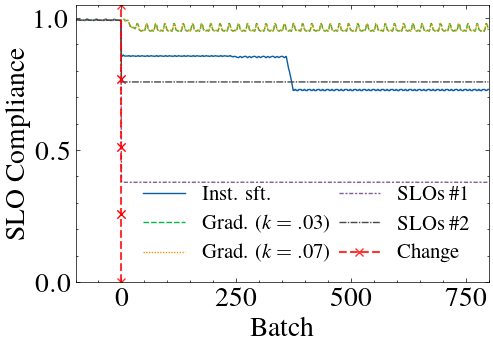

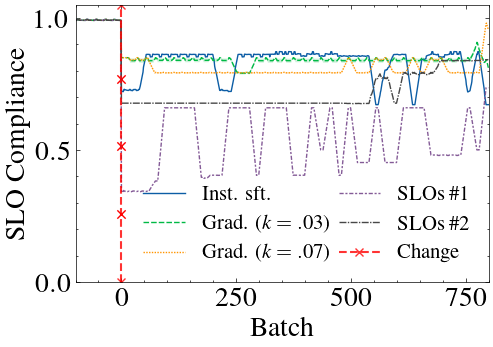

In [34]:
def plot_aif_short(dir_name, index, legend_loc=None, legend_cols=None):
    plt.figure(figsize=fig_size)

    aif_log_dir = os.path.join(log_dir, "aif_short_curves")
    base_exp_log = os.path.join(aif_log_dir, "long_buffer", "exp102_eval.csv")
    dir_path = os.path.join(aif_log_dir, dir_name)
    exp_names = ["Inst. sft.", "Grad. ($\\mathdefault{k=.03}$)", "Grad. ($\\mathdefault{k=.07}$)", "SLOs \#1", "SLOs \#2"]
    logs = [os.path.join(dir_path, f"exp{index}{exp_index}2_eval.csv") for exp_index in [1, 4, 5, 2, 3]]
    base_df = pd.read_csv(base_exp_log)
    dfs = [pd.read_csv(log) for log in logs]
    prepend_size = 100

    def get_processed_curve(df, curve_name):
        curve = rolling(get_eval_curve(df, curve_name))
        curve = [*rolling(get_eval_curve(base_df, curve_name))[-prepend_size:], *curve]
        return curve

    df = pd.DataFrame({
        "step": range(-prepend_size, 800),
        **{
            exp: get_processed_curve(df, "eval_mean_SLO_ALL")
            for exp, df in zip(exp_names, dfs)
        },
        **{
            f"{exp}_std": get_processed_curve(df, "eval_std_SLO_ALL")
            for exp, df in zip(exp_names, dfs)
        },
    })

    df_melted = pd.melt(df, ["step"], var_name="Experiment", value_vars=exp_names)
    sns.lineplot(df_melted, x="step", y="value", hue="Experiment", style="Experiment", legend=True)

    plt.axvline(0, color="red", ls="--", linewidth=1.5, alpha=0.8, marker="x", label="Change")
    ymax = plt.ylim()[1]
    delta = ymax / 4
    plt.scatter(x=[0] * 3, y=[delta * i for i in range(1, 4)], color="red", marker="x")

    for exp in exp_names:
        mean = df[exp]
        std = df[f"{exp}_std"]
        plt.fill_between(range(-prepend_size, 800), mean - std, mean + std, alpha=0.2)
    
    plt.legend(loc=legend_loc or "best", ncols=legend_cols or 1, columnspacing=0.4)

    plt.xlim([-prepend_size, 800])
    plt.ylim([0, 1.05])
    plt.xlabel("Batch")
    plt.ylabel("SLO Compliance")

    if save_figures:
        plt.savefig(get_plot_path(f"aif_short_{dir_name}_{index}.pdf"))
    plt.show()

with plt.rc_context({"font.size": 20, "legend.fontsize": 15}):
    plot_aif_short("long_buffer", 1, legend_loc="lower right", legend_cols=2)
    plot_aif_short("long_buffer", 6, legend_loc="lower right", legend_cols=2)
    plot_aif_short("short_buffer", 1, legend_loc="lower right", legend_cols=2)
    plot_aif_short("short_buffer", 6, legend_loc="lower right", legend_cols=2)